<a href="https://colab.research.google.com/github/dybbuk-dev/tempario/blob/main/rnn_containers_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import time

import numpy as np
import pandas as pd
import torch.optim as optim
import matplotlib.pyplot as plt
import holidays
from datetime import datetime, date

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf

try:
  from torchinfo import summary
except ImportError:
  !pip install torchinfo

from torchinfo import summary
from tqdm.notebook import tqdm

from google.colab import drive
drive.mount('/content/drive')

#!cp df.pkl /content/drive/MyDrive

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device,'available...')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cuda available...


In [2]:
def generate_cyclical_features(df, col_name, period, start_num=0):
  kwargs = {
              f'sin_{col_name}' : lambda x: np.sin(2*np.pi*(df[col_name]-start_num)/period),
              f'cos_{col_name}' : lambda x: np.cos(2*np.pi*(df[col_name]-start_num)/period)
            }
  return df.assign(**kwargs).drop(columns=[col_name])

In [3]:
def format_training_data(df, holidays, freq, generate_cyclical = False):
  df = df.groupby(pd.Grouper(freq = freq)).agg({'componentid':'count'})

  def is_holiday(date):
    date = date.replace(hour = 0)
    return 1 if (date in holidays) else 0

  def add_holiday_col(df, holidays):
    return df.assign(is_holiday = df.index.to_series().apply(is_holiday))

  df = (df
            .assign(month = df.index.month)
            .assign(hour = df.index.hour)
            .assign(minute = df.index.minute)
            .assign(day_of_week = df.index.dayofweek)
            .assign(week_of_year = df.index.isocalendar().week)
            .assign(is_holiday = df.index.to_series().apply(is_holiday))
        )

  df.rename(columns={'componentid':'value'}, inplace=True)

  if (generate_cyclical):
    df = generate_cyclical_features(df, 'day',         31, 1)
    df = generate_cyclical_features(df, 'month',       12, 1)
    df = generate_cyclical_features(df, 'hour',        23, 0)
    df = generate_cyclical_features(df, 'minute',      59, 0)
    df = generate_cyclical_features(df, 'day_of_week',  6, 0)


  return df

In [4]:
def get_scaler(scaler):
  scalers = {
    "minmax": MinMaxScaler,
    "standard": StandardScaler,
    "maxabs": MaxAbsScaler,
    "robust": RobustScaler,
  }

  return scalers.get(scaler.lower())()

In [5]:
def get_training_datasets(x, y, train_ratio, validation_ratio, test_ratio):
  # train is now 75% of the entire data set
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 1 - train_ratio)

  # test is now 10% of the initial data set
  # validation is now 15% of the initial data set
  x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size = test_ratio/(test_ratio + validation_ratio))

  return x_val, x_test, x_train, y_val, y_test, y_train

In [6]:
def get_model(model, model_params):
  models = {
    "lstm": LSTMModel,
    "gru": GRUModel,
  }
  return models.get(model.lower())(**model_params)

In [53]:
def calculate_metrics(df):
    result_metrics = {'mae' : mean_absolute_error(df.value, df.prediction),
                      'rmse' : mean_squared_error(df.value, df.prediction) ** 0.5,
                      'r2' : r2_score(df.value, df.prediction)}

    print("Mean Absolute Error:       ", round(result_metrics["mae"],2))
    print("Root Mean Squared Error:   ", round(result_metrics["rmse"],2))
    print("R^2 Score:                 ", round(result_metrics["r2"]*100,2))
    return result_metrics

In [8]:
def format_forecasts(forecasts, x_test, scaler):

  col = x_test.shape[len(x_test.shape) - 1]

  inverse_values = np.zeros((x_test.shape[0], col+1))
  inverse_values[:,0] = forecasts
  inverse_values = scaler.inverse_transform(inverse_values)

  return inverse_values[0]

In [9]:
def feature_label_split(df, target_col):
    y = df[[target_col]]
    X = df.drop(columns=[target_col])
    return X, y

In [10]:
def onehot_encode_pd(df, cols):
  one_hot_enc = make_column_transformer((OneHotEncoder(handle_unknown = 'ignore', drop='first'), cols), remainder='passthrough', verbose=True)

  data = one_hot_enc.fit_transform(df)
  data_df = pd.DataFrame(data, columns=one_hot_enc.get_feature_names_out(), index=df.index)
  return data

In [11]:
class Optimization:
    """Optimization is a helper class that allows training, validation, prediction.

    Optimization is a helper class that takes model, loss function, optimizer function
    learning scheduler (optional), early stopping (optional) as inputs. In return, it
    provides a framework to train and validate the models, and to predict future values
    based on the models.

    Attributes:
        model (RNNModel, LSTMModel, GRUModel): Model class created for the type of RNN
        loss_fn (torch.nn.modules.Loss): Loss function to calculate the losses
        optimizer (torch.optim.Optimizer): Optimizer function to optimize the loss function
        train_losses (list[float]): The loss values from the training
        val_losses (list[float]): The loss values from the validation
        last_epoch (int): The number of epochs that the models is trained
    """
    def __init__(self, model, loss_fn, optimizer):
      """
      Args:
          model (RNNModel, LSTMModel, GRUModel): Model class created for the type of RNN
          loss_fn (torch.nn.modules.Loss): Loss function to calculate the losses
          optimizer (torch.optim.Optimizer): Optimizer function to optimize the loss function
      """
      self.model = model.to(device)
      self.loss_fn = loss_fn
      self.optimizer = optimizer
      self.train_losses = []
      self.val_losses = []

    def train_step(self, x, y):
      """The method train_step completes one step of training.

      Given the features (x) and the target values (y) tensors, the method completes
      one step of the training. First, it activates the train mode to enable back prop.
      After generating predicted values (yhat) by doing forward propagation, it calculates
      the losses by using the loss function. Then, it computes the gradients by doing
      back propagation and updates the weights by calling step() function.

      Args:
          x (torch.Tensor): Tensor for features to train one step
          y (torch.Tensor): Tensor for target values to calculate losses

      """
      # Sets model to train mode
      self.model.train()

      # Makes predictions
      yhat = self.model(x)

      # Computes loss
      loss = self.loss_fn(y, yhat)

      # Computes gradients
      loss.backward()

      # Updates parameters and zeroes gradients
      self.optimizer.step()
      self.optimizer.zero_grad()

      # Returns the loss
      return loss.item()

    def train(self, train_loader, val_loader, batch_size=64, n_epochs=50, n_features=1):
      """The method train performs the model training

      The method takes DataLoaders for training and validation datasets, batch size for
      mini-batch training, number of epochs to train, and number of features as inputs.
      Then, it carries out the training by iteratively calling the method train_step for
      n_epochs times. If early stopping is enabled, then it  checks the stopping condition
      to decide whether the training needs to halt before n_epochs steps. Finally, it saves
      the model in a designated file path.

      Args:
          train_loader (torch.utils.data.DataLoader): DataLoader that stores training data
          val_loader (torch.utils.data.DataLoader): DataLoader that stores validation data
          batch_size (int): Batch size for mini-batch training
          n_epochs (int): Number of epochs, i.e., train steps, to train
          n_features (int): Number of feature columns

      """
      model_path = f'{self.model}_{datetime.now().strftime("%Y-%m-%d %H:%M:%S")}'

      for epoch in range(1, n_epochs + 1):
          batch_losses = []
          for x, label in train_loader:
              model.zero_grad()
              loss = self.train_step(x.to(device).float(), label.to(device).float())
              batch_losses.append(loss)
          training_loss = np.mean(batch_losses)
          self.train_losses.append(training_loss)

          with torch.no_grad():
              batch_val_losses = []
              for x, feature in val_loader:
                  x = x.view([batch_size, -1, n_features])
                  self.model.eval()
                  yhat = self.model(x.to(device).float())
                  val_loss = self.loss_fn(feature.to(device).float(), yhat.to(device).float()).item()
                  batch_val_losses.append(val_loss)
              validation_loss = np.mean(batch_val_losses)
              self.val_losses.append(validation_loss)

          if (epoch <= 10) | (epoch % 50 == 0):
              print(f"[{epoch}/{n_epochs}] Training loss: {training_loss:.4f}\t Validation loss: {validation_loss:.4f}")

      torch.save(self.model.state_dict(), model_path)

    def evaluate(self, test_loader, batch_size=1, n_features=1):
      """The method evaluate performs the model evaluation

      The method takes DataLoaders for the test dataset, batch size for mini-batch testing,
      and number of features as inputs. Similar to the model validation, it iteratively
      predicts the target values and calculates losses. Then, it returns two lists that
      hold the predictions and the actual values.

      Note:
          This method assumes that the prediction from the previous step is available at
          the time of the prediction, and only does one-step prediction into the future.

      Args:
          test_loader (torch.utils.data.DataLoader): DataLoader that stores test data
          batch_size (int): Batch size for mini-batch training
          n_features (int): Number of feature columns

      Returns:
          list[float]: The values predicted by the model
          list[float]: The actual values in the test set.

      """
      with torch.inference_mode():
        predictions = []
        values = []
        unscaled = []
        for x_test, y_test in test_loader:
          x_test = x_test.view([batch_size, -1, n_features])
          self.model.eval()
          yhat = self.model(x_test.to(device).float())
          predictions.append(yhat.cpu().detach().numpy())
          values.append(y_test.cpu().detach().numpy())

      predictions = np.array(predictions).reshape(-1)
      values = np.array(values).reshape(-1)


      return predictions, values

    def forecast_with_predictors(self, forecast_loader, batch_size=1, n_features=1, n_steps=100):
      """Forecasts values for RNNs with predictors and one-dimensional output

      The method takes DataLoader for the test dataset, batch size for mini-batch testing,
      number of features and number of steps to predict as inputs. Then it generates the
      future values for RNNs with one-dimensional output for the given n_steps. It uses the
      values from the predictors columns (features) to forecast the future values.

      Args:
          test_loader (torch.utils.data.DataLoader): DataLoader that stores test data
          batch_size (int): Batch size for mini-batch training
          n_features (int): Number of feature columns
          n_steps (int): Number of steps to predict future values

      Returns:
          list[float]: The values predicted by the model

      """
      step = 0
      with torch.inference_mode():
        predictions = []
        for x, _ in forecast_loader:
          x = x.view([batch_size, -1, n_features]).to(device).float()
          self.model.eval()
          yhat = self.model(x.to(device).float())
          predictions.append(yhat.cpu().detach().numpy())

          step += 1
          if step == n_steps:
              break

      predictions = np.array(predictions).reshape(-1)
      return predictions

    def forecast_with_lag_features(self, test_loader, batch_size=1, n_features=1, n_steps=100):
      """The method forecast() forecasts values for RNNs with one-dimensional output

      The method takes DataLoader for the test dataset, batch size for mini-batch testing,
      number of features and number of steps to predict as inputs. Then it generates the
      future values for RNNs with one-dimensional output for the given n_steps.

      It uses the last item from the Test DataLoader to create the next input tensor (X).
      First, it shifts the tensor by one and adds the actual value from the target tensor (y).
      For the given n_steps, it goes on to predict the values for the next step and to update
      the input tensor for the next prediction. During each iteration it stores the predicted
      values in the list.

      Note:
          Unlike the method evaluate: This method does not assume that the prediction from
          the previous step is available the time of the prediction. Hence, it takes the
          first item in the Test DataLoader then only does one-step prediction into the future.
          After predicting the value for the next step, it updates the input tensor (X)
          by shifting the tensor and then adding the most recent prediction.

      Args:
          test_loader (torch.utils.data.DataLoader): DataLoader that stores test data
          batch_size (int): Batch size for mini-batch training
          n_features (int): Number of feature columns
          n_steps (int): Number of steps to predict future values

      Returns:
          list[float]: The values predicted by the model

      """
      test_loader_iter = iter(test_loader)
      predictions = []

      *_, (X, y) = test_loader_iter

      y = y.to(device).detach().numpy()
      X = X.view([batch_size, -1, n_features]).to(device)
      X = torch.roll(X, shifts=1, dims=2)
      X[..., -1, 0] = y.item(0)

      with torch.no_grad():
        self.model.eval()
        for _ in range(n_steps):
          X = X.view([batch_size, -1, n_features]).to(device)
          yhat = self.model(X)
          yhat = yhat.to(device).detach().numpy()
          X = torch.roll(X, shifts=1, dims=2)
          X[..., -1, 0] = yhat.item(0)
          predictions.append(yhat.item(0))

      return predictions

    def plot_losses(self):
      """The method plots the calculated loss values for training and validation
      """
      plt.figure(figsize=(10,6))
      plt.plot(self.train_losses, label="Training loss")
      plt.plot(self.val_losses, label="Validation loss")
      plt.legend()
      plt.title("Losses")
      plt.show()
      plt.close()

In [43]:
class GRUModel(nn.Module):
  """GRUModel class extends nn.Module class and works as a constructor for GRUs.

      GRUModel class initiates a GRU module based on PyTorch's nn.Module class.
      It has only two methods, namely init() and forward(). While the init()
      method initiates the model with the given input parameters, the forward()
      method defines how the forward propagation needs to be calculated.
      Since PyTorch automatically defines back propagation, there is no need
      to define back propagation method.

      Attributes:
          hidden_dim (int): The number of nodes in each layer
          layer_dim (str): The number of layers in the network
          gru (nn.GRU): The GRU model constructed with the input parameters.
          fc (nn.Linear): The fully connected layer to convert the final state
                          of GRUs to our desired output shape.

  """
  def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
    """The __init__ method that initiates a GRU instance.

    Args:
        input_dim (int): The number of nodes in the input layer
        hidden_dim (int): The number of nodes in each layer
        layer_dim (int): The number of layers in the network
        output_dim (int): The number of nodes in the output layer
        dropout_prob (float): The probability of nodes being dropped out

    """
    super(GRUModel, self).__init__()

    # Defining the number of layers and the nodes in each layer
    self.layer_dim = layer_dim
    self.hidden_dim = hidden_dim

    # GRU layers
    self.gru = nn.GRU(
        input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
    )

    # Fully connected layer
    self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, x):
    """The forward method takes input tensor x and does forward propagation

    Args:
        x (torch.Tensor): The input tensor of the shape (batch size, sequence length, input_dim)

    Returns:
        torch.Tensor: The output tensor of the shape (batch size, output_dim)

    """
    # Initializing hidden state for first input with zeros
    h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim, device=x.device).requires_grad_()

    # Forward propagation by passing in the input and hidden state into the model
    out, _ = self.gru(x, h0.detach())

    # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
    # so that it can fit into the fully connected layer
    out = out[:, -1, :]

    # Convert the final state to our desired output shape (batch_size, output_dim)
    out = self.fc(out)

    return out

In [13]:
class LSTMModel(nn.Module):
  """LSTMModel class extends nn.Module class and works as a constructor for LSTMs.

      LSTMModel class initiates a LSTM module based on PyTorch's nn.Module class.
      It has only two methods, namely init() and forward(). While the init()
      method initiates the model with the given input parameters, the forward()
      method defines how the forward propagation needs to be calculated.
      Since PyTorch automatically defines back propagation, there is no need
      to define back propagation method.

      Attributes:
          hidden_dim (int): The number of nodes in each layer
          layer_dim (str): The number of layers in the network
          lstm (nn.LSTM): The LSTM model constructed with the input parameters.
          fc (nn.Linear): The fully connected layer to convert the final state
                          of LSTMs to our desired output shape.

  """
  def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
      """The __init__ method that initiates a LSTM instance.

      Args:
          input_dim (int): The number of nodes in the input layer
          hidden_dim (int): The number of nodes in each layer
          layer_dim (int): The number of layers in the network
          output_dim (int): The number of nodes in the output layer
          dropout_prob (float): The probability of nodes being dropped out

      """
      super(LSTMModel, self).__init__()

      # Defining the number of layers and the nodes in each layer
      self.hidden_dim = hidden_dim
      self.layer_dim = layer_dim

      # LSTM layers
      self.lstm = nn.LSTM(
          input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
      )

      # Fully connected layer
      self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, x):
      """The forward method takes input tensor x and does forward propagation

      Args:
          x (torch.Tensor): The input tensor of the shape (batch size, sequence length, input_dim)

      Returns:
          torch.Tensor: The output tensor of the shape (batch size, output_dim)

      """
      # Initializing hidden state for first input with zeros
      h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim, device=x.device).requires_grad_()

      # Initializing cell state for first input with zeros
      c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim, device=x.device).requires_grad_()

      # We need to detach as we are doing truncated backpropagation through time (BPTT)
      # If we don't, we'll backprop all the way to the start even after going through another batch
      # Forward propagation by passing in the input, hidden state, and cell state into the model
      out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

      # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
      # so that it can fit into the fully connected layer
      out = out[:, -1, :]

      # Convert the final state to our desired output shape (batch_size, output_dim)
      out = self.fc(out)

      return out

In [23]:
#df_raw = pd.read_pickle('/content/drive/MyDrive/df.pkl')
#df_raw.rename(columns={'transactions':'value'}, inplace=True)

df_raw = pd.read_pickle('/content/drive/MyDrive/filesdf.pkl')

In [44]:
batch_size = 32
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

df = format_training_data(df_raw, holidays.US(), '1Min')

x, y = feature_label_split(df,'value')

y_scaler = get_scaler('minmax')
y_scaled = y_scaler.fit_transform(y.values)

x_scaler = get_scaler('minmax')
x_scaled = x_scaler.fit_transform(x.values)

x_val, x_test, x_train, y_val, y_test, y_train = get_training_datasets(x_scaled, y_scaled, train_ratio, validation_ratio, test_ratio)

x_val_3d = np.expand_dims(x_val, axis=1)
x_test_3d = np.expand_dims(x_test, axis=1)
x_train_3d = np.expand_dims(x_train, axis=1)

In [45]:
train_data = TensorDataset(torch.Tensor(x_train_3d), torch.Tensor(y_train))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)

val_data = TensorDataset(torch.Tensor(x_val_3d), torch.Tensor(y_val))
val_loader = DataLoader(val_data, shuffle=True, batch_size=batch_size, drop_last=True)

test_data = TensorDataset(torch.Tensor(x_test_3d), torch.Tensor(y_test))
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size, drop_last=True)

test_loader_one = DataLoader(test_data, batch_size=1, shuffle=True, drop_last=True)

[1/20] Training loss: 0.0152	 Validation loss: 0.0056
[2/20] Training loss: 0.0066	 Validation loss: 0.0065
[3/20] Training loss: 0.0059	 Validation loss: 0.0048
[4/20] Training loss: 0.0052	 Validation loss: 0.0046
[5/20] Training loss: 0.0041	 Validation loss: 0.0024
[6/20] Training loss: 0.0031	 Validation loss: 0.0023
[7/20] Training loss: 0.0028	 Validation loss: 0.0024
[8/20] Training loss: 0.0026	 Validation loss: 0.0021
[9/20] Training loss: 0.0025	 Validation loss: 0.0019
[10/20] Training loss: 0.0024	 Validation loss: 0.0019


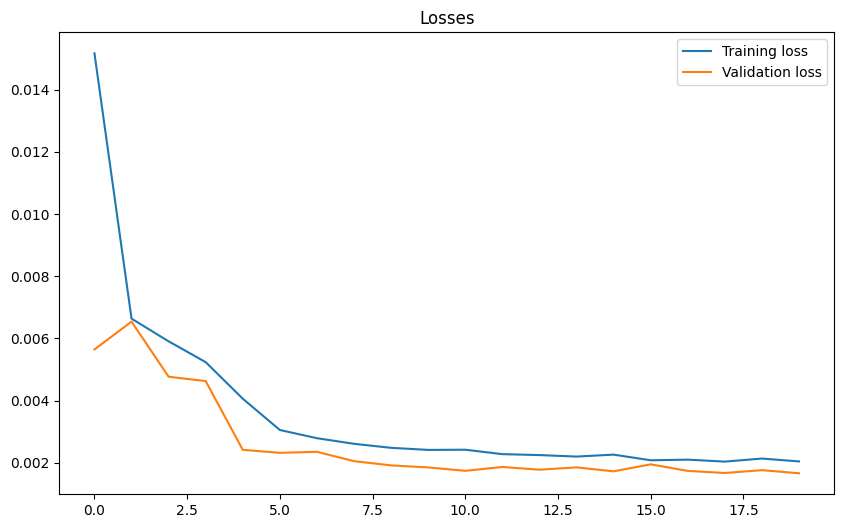

In [46]:
input_dim = x_train.shape[len(x_train.shape)-1]
output_dim = 1
hidden_dim = 64
layer_dim = x_train.shape[1]
dropout = 0.2
n_epochs = 20
learning_rate = 1e-2
weight_decay = 1e-6


model_params = {
                  'input_dim': input_dim,
                  'hidden_dim': hidden_dim,
                  'layer_dim': layer_dim,
                  'output_dim': output_dim,
                  'dropout_prob': dropout
                }

model = get_model('gru', model_params)

loss_fn = nn.MSELoss()
optimizer = optim.Adamax(model.parameters(), lr=learning_rate, weight_decay=0)
opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt.plot_losses()

In [47]:
predictions, values = opt.evaluate(
  test_loader_one,
  batch_size=1,
  n_features=input_dim
)

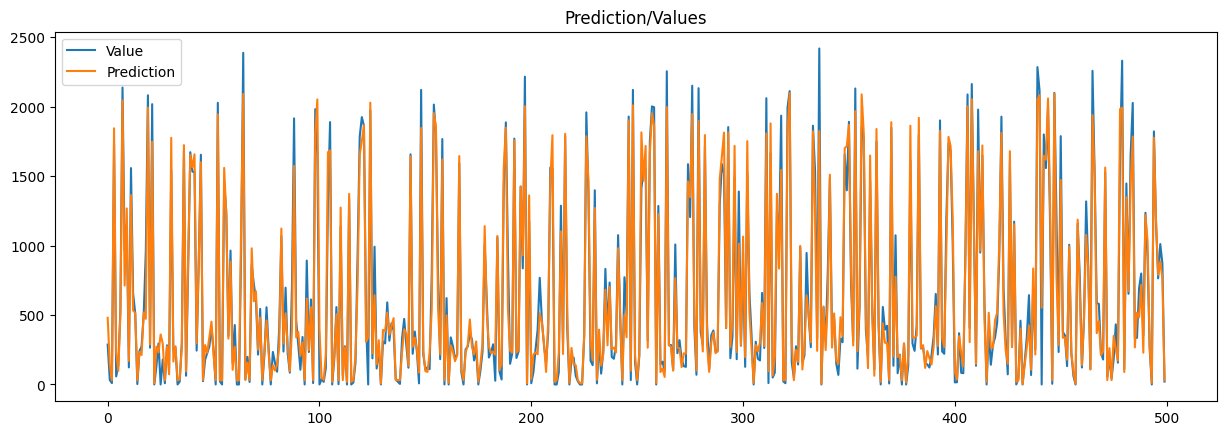

Mean Absolute Error:        95.56
Root Mean Squared Error:    140.04
R^2 Score:                  95.86


In [54]:
inverse_values = y_scaler.inverse_transform(values.reshape(-1, 1))
inverse_predictions = y_scaler.inverse_transform(predictions.reshape(-1, 1))
df_result = pd.DataFrame({'value': inverse_values.reshape(-1), 'prediction': inverse_predictions.reshape(-1)})

plt.figure().set_figwidth(15)
plt.plot(inverse_values[0:500], label="Value")
plt.plot(inverse_predictions[0:500], label="Prediction")
plt.legend()
plt.title("Prediction/Values")
plt.show()
plt.close()

result_metrics = calculate_metrics(df_result)

In [50]:
round(0.9585862870500584*100,2)

95.86

In [40]:
def get_datetime_index(df):
  return (
      pd.to_datetime(df.index[-1]) + (pd.to_datetime(df.index[-1]) - pd.to_datetime(df.index[-2])),
      pd.to_datetime(df.index[-1]) - pd.to_datetime(df.index[-2]),
  )

start_date, freq = get_datetime_index(df)
index = pd.date_range(start=start_date, freq=freq, periods=2880)
df_forecast = pd.DataFrame(index=index)
df_forecast['componentid'] = 'dummy'

In [41]:
df_predict = format_training_data(df_forecast, holidays.US(), '1Min')
df_predict['value'] = 0

scaler_x = get_scaler('minmax')
x_fitted = scaler_x.fit_transform(x.values)

scaler_y = get_scaler('minmax')
y_fitted = scaler_y.fit_transform(y.values)

x_fitted_3d = np.expand_dims(x_fitted, axis=1)

forecast_dataset = TensorDataset(torch.Tensor(x_fitted_3d), torch.Tensor(y_fitted))
forecast_loader = DataLoader(forecast_dataset, batch_size=1, shuffle=False, drop_last=True)

forecasts = opt.forecast_with_predictors(
                                            forecast_loader,
                                            batch_size=1,
                                            n_features=input_dim,
                                            n_steps=index.shape[0]
                                        )

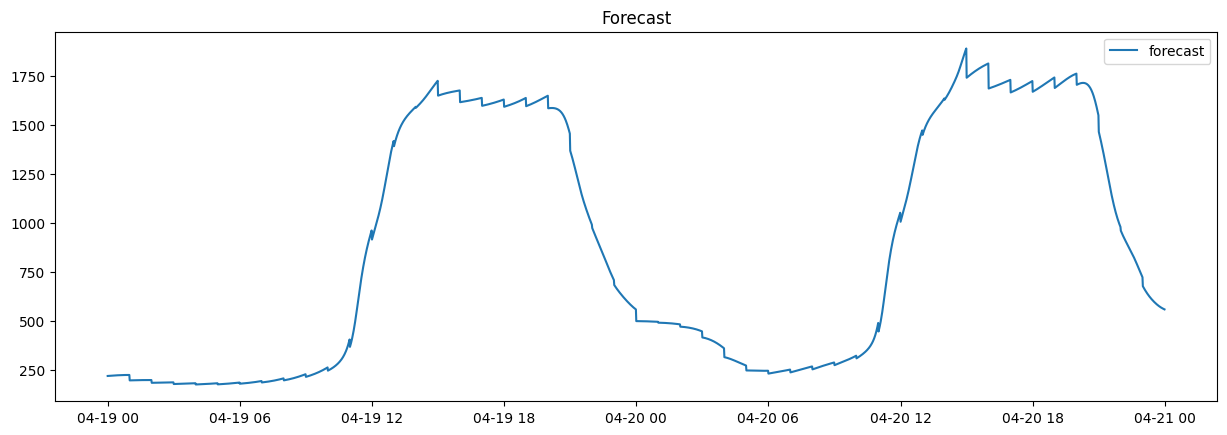

In [42]:
def format_forecasts(forecasts, index, scaler):
    preds = scaler.inverse_transform(forecasts.reshape(-1, 1)).reshape(len(index))
    df_forecast = pd.DataFrame(data={"prediction": preds}, index=index)
    df_result = df_forecast.sort_index()
    return df_result

df_forecast = format_forecasts(forecasts, index, scaler_y)

plt.figure().set_figwidth(15)
plt.plot(df_forecast, label="forecast")
plt.legend()
plt.title("Forecast")

plt.show()
plt.close()